In [53]:
import os
import pandas as pd

In [54]:
cp_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_cplex_cp.txt'
ortools_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_ortools.txt'
gurobi_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_gurobi.txt'
cplp_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_cplex_lp.txt'

In [55]:
cp_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_cplex_cp.txt'
ortools_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_ortools.txt'
cplp_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_cplex_lp_rewritten.txt'
gurobi_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_gurobi.txt'

In [56]:
def read_file(file : str) -> pd.DataFrame:
    file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    df = pd.DataFrame(file_content)
    del file_content
    df = df.drop(columns=['result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram'])
    df = df[~df['name'].str.startswith('Error')]
    df = df[df['fitness_value'] != float('inf')]
    return df

In [57]:
cp_fjssp = read_file(cp_path_fjssp)
cp_fjssp_w = read_file(cp_path_fjssp_w)

In [58]:
cplp_fjssp = read_file(cplp_path_fjssp)
cplp_fjssp_w = read_file(cplp_path_fjssp_w)

In [59]:
gurobi_fjssp = read_file(gurobi_path_fjssp)
gurobi_fjssp_w = read_file(gurobi_path_fjssp_w)

In [60]:
ortools_fjssp = read_file(ortools_path_fjssp)
ortools_fjssp_w = read_file(ortools_path_fjssp_w)

In [61]:
ga_path_fjssp = r'C:\Users\huda\Downloads\ga_comparison\ga'
ga_path_fjssp_w = r'C:\Users\huda\Downloads\ga_comparison\fjssp_w'

In [62]:
import json
def rewrite(path_to_results):
    files = os.listdir(path_to_results)
    json_data = {}
    for file in files:
        with open(path_to_results + "\\" + file, 'r') as f:
            content = f.read()
            content = '{"' + content[1:7] + '"' + content[8:-1] + ']' + '}'
            json_data[file[:-9]] = content
    return json_data
ga_files = os.listdir(ga_path_fjssp)
ga_fjssp_data = rewrite(ga_path_fjssp)

In [63]:
ga_fjssp_w_data = dict()
files = os.listdir(ga_path_fjssp_w)
for file in files:
    with open(ga_path_fjssp_w + '/' + file, 'r') as f:
        json_data = json.loads(f.read())
        ga_fjssp_w_data[file[:-9]] = json_data

In [64]:
ga_average_fjssp = dict()
ga_average_fjssp_w = dict()
ga_best_fjssp = dict()
ga_best_fjssp_w = dict()
for instance in ga_fjssp_data:
    ga_best_fjssp[instance] = float('inf')
    ga_average_fjssp[instance] = 0
    ga_instance_data = json.loads(ga_fjssp_data[instance])
    for run in ga_instance_data['result']:
        fitness = run['Result']['Fitness']['Makespan']
        if fitness < ga_best_fjssp[instance]:
            ga_best_fjssp[instance] = fitness
        ga_average_fjssp[instance] += fitness
    ga_average_fjssp[instance] /= len(ga_instance_data['result'])
for instance in ga_fjssp_w_data:
    ga_best_fjssp_w[instance] = float('inf')
    ga_average_fjssp_w[instance] = 0
    for run in ga_fjssp_w_data[instance]['results']:
        fitness = run['Result']['Fitness']['Makespan']
        if fitness < ga_best_fjssp_w[instance]:
            ga_best_fjssp_w[instance] = fitness
        ga_average_fjssp_w[instance] += fitness
    ga_average_fjssp_w[instance] /= len( ga_fjssp_w_data[instance]['results'])
    

In [65]:
ortools_fjssp[ortools_fjssp['optimization_status'] == 1].count()

name                   20
optimization_status    20
fitness_value          20
lower_bound            20
runtime                20
resource_history       20
best_result_history     0
dtype: int64

In [66]:
ortools_fjssp_w[ortools_fjssp_w['optimization_status'] == 1].count()

name                   39
optimization_status    39
fitness_value          39
lower_bound            39
runtime                39
resource_history       39
best_result_history    39
dtype: int64

In [67]:
def setup_dict():
    compare = dict()
    compare['worker'] = dict()
    compare['no_worker'] = dict()
    return compare

In [68]:
solver = dict()
solver['cplex_cp'] = dict()
solver['ortools'] = dict()
solver['ga_best'] = dict()
solver['ga_average'] = dict()
solver['gurobi'] = dict()
#solver['cplex_lp'] = dict()

In [69]:
compare = setup_dict()
for instance in ga_average_fjssp:
    compare['no_worker'][instance] = {
        'fitness': ga_average_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
for instance in ga_average_fjssp_w:
    compare['worker'][instance] = {
        'fitness': ga_average_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
solver['ga_average'] = compare

In [70]:
compare = setup_dict()
for instance in ga_best_fjssp:
    compare['no_worker'][instance] = {
        'fitness': ga_best_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
for instance in ga_best_fjssp_w:
    compare['worker'][instance] = {
        'fitness': ga_best_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
solver['ga_best'] = compare

In [71]:
def remap(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[0].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[0].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[-1]
    if values[0].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('r'):
        return 'HurinkRdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[0].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[0].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[0].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name

In [72]:
def extract_solver_data(fjssp, fjssp_w):
    compare = setup_dict()
    for index, row in fjssp.iterrows():
        compare['no_worker'][row['name']] = {
            'fitness': row['fitness_value'],
            'lower_bound': row['lower_bound'],
            'status': row['optimization_status'],
            'runtime': row['runtime']
        }
    for index, row in fjssp_w.iterrows():
        name = remap(row['name'][2:-12])
        if name in compare['no_worker']:
            compare['worker'][name] = {
                'fitness': row['fitness_value'],
                'lower_bound': row['lower_bound'],
                'status': row['optimization_status'],
                'runtime': row['runtime']
            }
    return compare

In [73]:
solver['cplex_cp'] = extract_solver_data(cp_fjssp, cp_fjssp_w)
#solver['cplex_lp'] = extract_solver_data(cplp_fjssp, cplp_fjssp_w)
solver['gurobi'] = extract_solver_data(gurobi_fjssp, gurobi_fjssp_w)
solver['ortools'] = extract_solver_data(ortools_fjssp, ortools_fjssp_w)

In [74]:
import statistics
import math

def calculate_flexibility(machines_for_all_operations, n_machines): 
    counts = []

    for m in machines_for_all_operations:
        counts.append(len(m))
    
    return statistics.mean(counts) / n_machines

def calculate_duration_variety(durations):
    counts = []

    for d in durations:
        counts.append(len(d))

    return len(set(counts)) / len(counts)

def calculate_average_operations(job_sequence):
    n_jobs = 1
    counts = [1]
    for i in range(1, len(job_sequence)):
        if job_sequence[i] != job_sequence[i-1]:
            n_jobs+=1
            counts.append(0)
        counts[-1] += 1
    return (sum(counts))/n_jobs


In [75]:
def calculate_duration_features_workers(durations):
    all_durations = []
    for duration in durations:
        for d in duration:
            all_durations.extend(d)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    stdev = statistics.stdev(all_durations)
    return min_duration, max_duration, span, stdev

def calculate_duration_features(durations):
    all_durations = []
    for duration in durations:
        all_durations.extend(duration)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    #stdev = statistics.stdev(all_durations)
    mean = sum(all_durations)/len(all_durations)
    var = sum(pow(x-mean, 2) for x in all_durations) / len(all_durations)
    stdev = math.sqrt(var)
    return min_duration, max_duration, span, stdev


In [ ]:
def remap_full(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[1].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[1].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[-1]
    if values[1].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('r'):
        return 'HurinkRdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[1].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[1].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[1].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name

from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser, BenchmarkParser
import os
includeWorkers = False
if includeWorkers:
    path = r'C:\Users\huda\Downloads\benchmarks_with_workers\benchmarks_with_workers'
    parser = WorkerBenchmarkParser()
else:
    path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks\all'
    parser = BenchmarkParser()
instances = os.listdir(path)
instance_data = dict()
consider_duration_features = True
for instance in instances:
    encoding = parser.parse_benchmark(path + "\\" + instance)
    feature_vector = []
    min_d, max_d, d_span, d_stdev = calculate_duration_features(encoding.durations()) if not includeWorkers else calculate_duration_features_workers(encoding.durations())
    #TODO: worker data, or just do it with base FJSSP since all benchmarks are transformed in the same way
    extracted_data = {
        "name": instance,
        "n_jobs": encoding.n_jobs(), 
        "n_machines": encoding.n_machines(),
        "n_operations": encoding.n_operations(),
        "durations": encoding.durations(),
        "job_sequence": encoding.job_sequence(),
        "machines_for_all_operations": encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(),
        "flexibility": calculate_flexibility(encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(), encoding.n_machines()),
        "duration_variety": calculate_duration_variety(encoding.durations()),
        "average_operations": calculate_average_operations(encoding.job_sequence()),
        "min_duration": min_d,
        "max_duration": max_d,
        "duration_span": d_span,
        "duration_std": d_stdev
    }
    instance_data[instance[:-4] if not includeWorkers else remap_full(instance[:-12])] = extracted_data


In [77]:
def print_instance(data):
    print(f"# Operations: {data['n_operations']} | # Machines: {data['n_machines']} | Flexibility: {data['flexibility']} | Duration Variety: {data['duration_variety']}")

In [78]:
def get_diff(solver, filter : bool = False, verbose : bool = False):
    diff = []
    o = []
    m = []
    f = []
    dv = []
    for instance in solver['worker']:
        if filter and min(solver["no_worker"][instance]["runtime"], 1200) == min(solver["worker"][instance]["runtime"], 1200):
            continue
        if verbose:
            print(instance)
            print_instance(instance_data[instance])
            print(f'FJSSP Status: {solver["no_worker"][instance]["status"]} | FJSSP-W Status: {solver["worker"][instance]["status"]}')
            print(f'FJSSP Runtime: {solver["no_worker"][instance]["runtime"]} | FJSSP-W Status: {solver["worker"][instance]["runtime"]}')
        diff.append(abs(solver["worker"][instance]["runtime"]-solver["no_worker"][instance]["runtime"]))
        o.append(instance_data[instance]['n_operations'])
        m.append(instance_data[instance]['n_machines'])
        f.append(instance_data[instance]['flexibility'])
        dv.append(instance_data[instance]['duration_variety'])
    return diff, o, m, f, dv

In [79]:
import matplotlib.pyplot as plt
def plot_runtime_difference(diff, o, m, f, dv, filter : bool = False):
    fig = plt.figure(layout='tight', figsize=(15, 8))
    axs = fig.subplots(2, 2)
    fig.suptitle(f'{"(Filtered)" if filter else ""} Benchmark Selection - FJSSP Benchmark Attributes')
    axs[0][0].scatter(diff, o)
    axs[0][0].set_title('Operations')
    axs[0][0].set_xlabel('runtime worker - runtime no worker')
    axs[0][0].set_ylabel('# operations')
    axs[0][1].scatter(diff, m)
    axs[0][1].set_title('Machines')
    axs[0][1].set_xlabel('runtime worker - runtime no worker')
    axs[0][1].set_ylabel('# machines')
    axs[1][0].scatter(diff, f)
    axs[1][0].set_title('Flexibility')
    axs[1][0].set_xlabel('runtime worker - runtime no worker')
    axs[1][0].set_ylabel('flexibility')
    axs[1][1].scatter(diff, dv)
    axs[1][1].set_title('Duration Variety')
    axs[1][1].set_xlabel('runtime worker - runtime no worker')
    axs[1][1].set_ylabel('duration variety')
    plt.show()


In [80]:
diff, o, m, f, dv = get_diff(solver['cplex_cp'], filter=True)

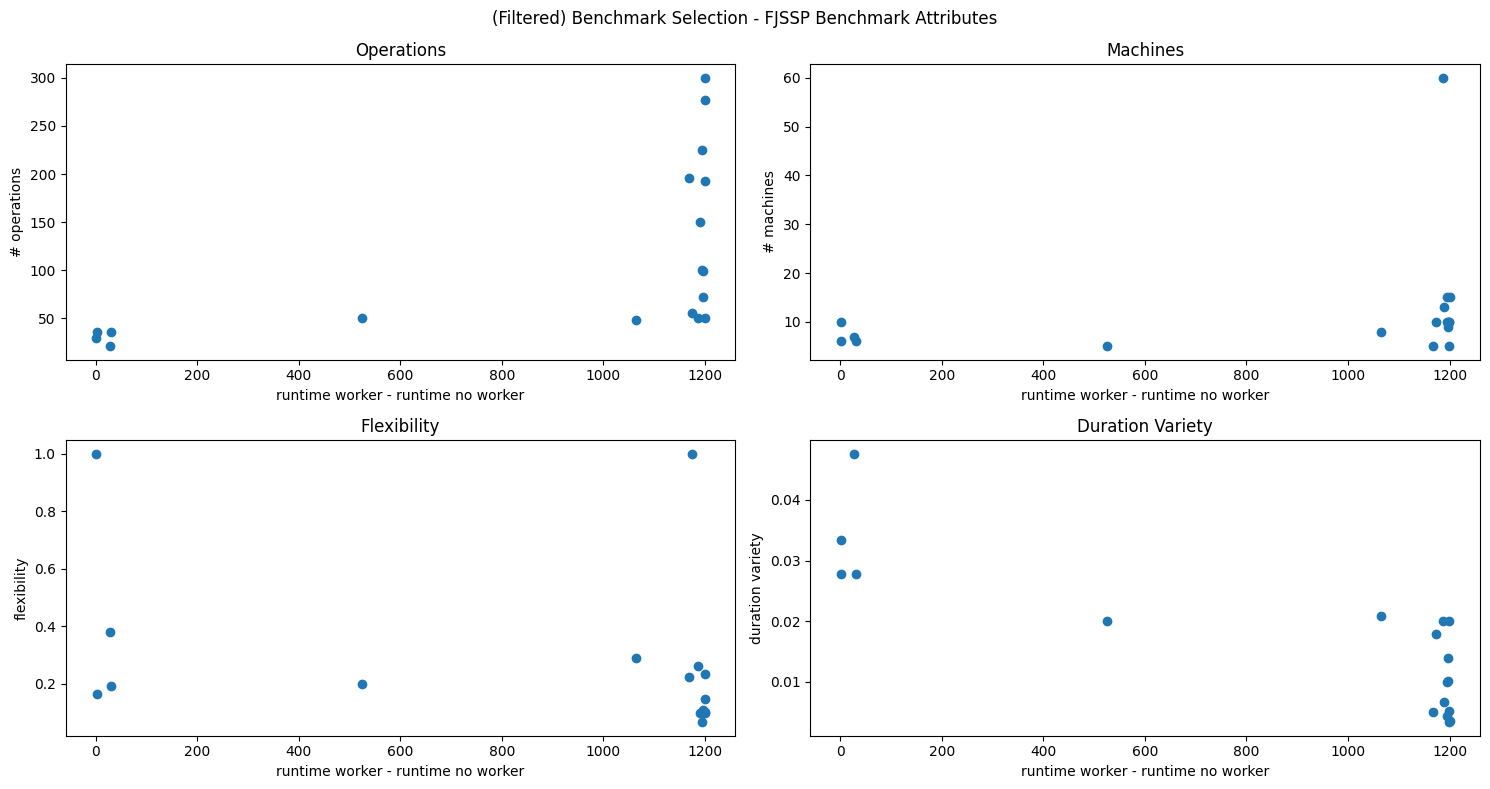

In [81]:
plot_runtime_difference(diff, o, m, f, dv, True)

In [82]:
diff, o, m, f, dv = get_diff(solver['ortools'], filter=True)

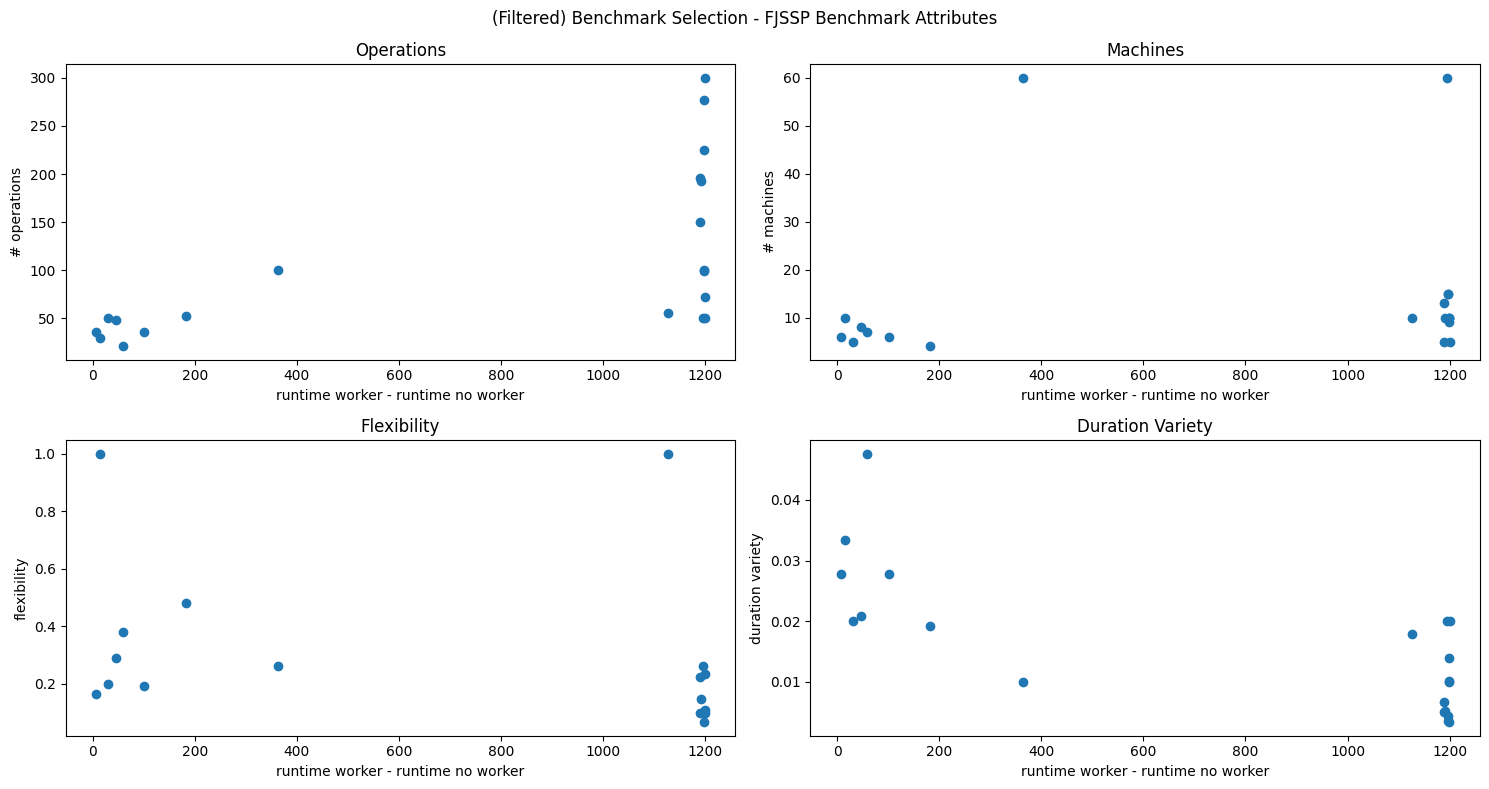

In [83]:
plot_runtime_difference(diff, o, m, f, dv, True)

In [84]:
def get_comparison(data, instance, column, max = False):
    best_fjssp = float('inf')
    best_fjssp_w = float('inf')
    for key in data.keys():
        if instance in data[key]['no_worker']:
            fitness_fjssp = data[key]['no_worker'][instance]['fitness']#optimizer['no_worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp < best_fjssp:
                best_fjssp = fitness_fjssp
        if instance in data[key]['worker']:
            fitness_fjssp_w = data[key]['worker'][instance]['fitness']#optimizer.loc[optimizer['worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp_w < best_fjssp_w:
                best_fjssp_w = fitness_fjssp_w
    return best_fjssp, best_fjssp_w

def calculate_value(fitness, best):
    return ((fitness - best) / best)

def get_cdf_comparison_vector(data : dict, column, max, instances):
    results = []
    for _ in data:
        results.append([[],[]])
    for instance in instances:
        best_fjssp, best_fjssp_w = get_comparison(data, instance, column, max)
        i = 0
        for key in data.keys():
            if instance in data[key]['no_worker']:
                results[i][0].append(calculate_value(data[key]['no_worker'][instance]['fitness'], best_fjssp))
            if instance in data[key]['worker']:
                results[i][1].append(calculate_value(data[key]['worker'][instance]['fitness'], best_fjssp_w))
            i += 1
    for result in results:
        result[0].sort()
        result[1].sort()
    return results

In [85]:
plt.rcParams['axes.grid'] = True
def ecdf_inf(data, column = 'fitness_value', max : bool = False, n_instances : int = 30, labels : list[str] = [], instances : list[str] = [], colors : list[str] = [], hlines : list = []):
    vectors = get_cdf_comparison_vector(data, column, max, instances)
    plot_vectors = []

    for vector in vectors:
        plot_vectors.append([[[0.0],[0.0]], [[0.0],[0.0]]])
        i = 1
        while i < len(vector[0]):
            if vector[0][i] == float('inf'):
                break
            if vector[0][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0][0].append(vector[0][i-1])
            plot_vectors[-1][0][1].append((i-1)/n_instances)
            i += 1
        i = 1
        while i < len(vector[1]):
            if vector[1][i] == float('inf'):
                break
            if vector[1][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][1][0].append(vector[1][i-1])
            plot_vectors[-1][1][1].append((i-1)/n_instances)
            i += 1
    fig = plt.figure(layout='tight', figsize=(5, 7))
    axs = fig.subplots(2)
    for i in range(len(vectors)):
        axs[0].plot(plot_vectors[i][0][0], plot_vectors[i][0][1], label=[labels[i]], c=colors[i], linestyle='solid')
    axs[0].set_title('FJSSP')
    axs[0].set_xlim(-0.01, 0.7)
    axs[0].set_xlabel('$\delta_{rel}$')
    axs[0].set_ylabel('Portion of instances within Gap')
    axs[0].axhline(y=hlines[0], alpha=0.7, color='black', linestyle='dotted', label='optimal')
    axs[0].legend()
    for i in range(len(vectors)):
        axs[1].plot(plot_vectors[i][1][0], plot_vectors[i][1][1], label=[labels[i]], c=colors[i])
    axs[1].axhline(y=hlines[1], alpha=0.7, color='black', linestyle='dotted', label='optimal')
    axs[1].set_title('FJSSP-W')
    axs[1].set_xlabel('$\delta_{rel}$')
    axs[1].set_ylabel('Portion of instances within Gap')
    axs[1].set_xlim(-0.01, 0.7)
    axs[1].legend()
    #for i in range(len(vectors)):
    #    plt.plot(plot_vectors[i][0][0], plot_vectors[i][0][1], label=[labels[i] + ' FJSSP'], c=colors[i], linestyle='dashed', alpha=0.7)
    #    plt.legend()
    #    plt.plot(plot_vectors[i][1][0], plot_vectors[i][1][1], label=[labels[i]+ ' FJSSP-W'], c=colors[i], alpha=0.7)
    #    plt.legend()
    #plt.xlim(-0.1, 1.0)
    plt.legend()
    #plt.title('FJSSP - FJSSP-W')
    plt.show()


In [86]:
optimal_instances = {'no_worker': [], 'worker': []}
for instance in solver['ga_best']['worker']:
    for s in solver:
        if s == 'cplex_cp' or s == 'ortools':
            if instance in solver[s]['no_worker']:
                if solver[s]['no_worker'][instance]['status'] == 1 and instance not in optimal_instances['no_worker']:
                        optimal_instances['no_worker'].append(instance)
            if instance in solver[s]['worker']:
                if solver[s]['worker'][instance]['status'] == 1 and instance not in optimal_instances['worker']:
                    optimal_instances['worker'].append(instance)

In [87]:
h_line_fjssp = len(optimal_instances['no_worker'])/len(solver['ga_best']['worker'])
h_line_fjssp_w = len(optimal_instances['worker'])/len(solver['ga_best']['worker'])

In [88]:
len(optimal_instances['no_worker'])

20

In [89]:
len(optimal_instances['worker'])

5

In [90]:
print(h_line_fjssp)
print(h_line_fjssp_w)

0.6666666666666666
0.16666666666666666


In [91]:
filtered_instances = list(solver['cplex_cp']['worker'].keys())

In [92]:
solver['ga_best']['worker']

{'Behnke42': {'fitness': 80.0},
 'Behnke46': {'fitness': 110.0},
 'Behnke60': {'fitness': 491.0},
 'BrandimarteMk12': {'fitness': 479.0},
 'BrandimarteMk14': {'fitness': 640.0},
 'BrandimarteMk7': {'fitness': 143.0},
 'ChambersBarnes10': {'fitness': 949.0},
 'DPpaulli1': {'fitness': 2728.0},
 'DPpaulli15': {'fitness': 2328.0},
 'DPpaulli18': {'fitness': 2305.0},
 'DPpaulli9': {'fitness': 2270.0},
 'Fattahi14': {'fitness': 538.0},
 'Fattahi20': {'fitness': 1208.0},
 'HurinkEdata1': {'fitness': 51.0},
 'HurinkEdata6': {'fitness': 601.0},
 'HurinkRdata28': {'fitness': 909.0},
 'HurinkRdata38': {'fitness': 1780.0},
 'HurinkRdata50': {'fitness': 5791.0},
 'HurinkSdata1': {'fitness': 52.0},
 'HurinkSdata38': {'fitness': 2005.0},
 'HurinkSdata40': {'fitness': 1640.0},
 'HurinkSdata54': {'fitness': 7954.0},
 'HurinkSdata61': {'fitness': 1468.0},
 'HurinkSdata63': {'fitness': 605.0},
 'HurinkSdata8': {'fitness': 565.0},
 'HurinkVdata18': {'fitness': 1827.0},
 'HurinkVdata30': {'fitness': 1178.0

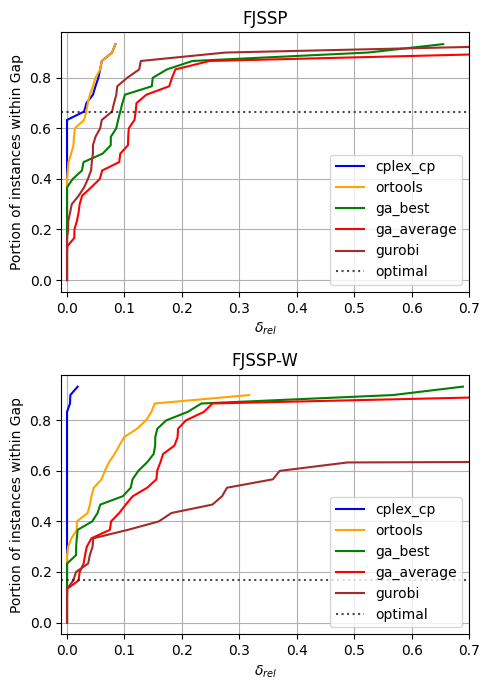

In [93]:
ecdf_inf(solver, instances=filtered_instances, labels=list(solver.keys()), colors=['blue', 'orange', 'green', 'red', 'brown', 'yellow'], hlines=[h_line_fjssp, h_line_fjssp_w])
#ecdf_inf(solver['cplex_cp']['no_worker'], instances=filtered_instances)

In [94]:
solver['cplex_cp']['worker']['HurinkSdata1']

{'fitness': 52.0, 'lower_bound': 52.0, 'status': 1.0, 'runtime': 1.898}

In [95]:
solver['ortools']['worker']['HurinkSdata1']

{'fitness': 52.0,
 'lower_bound': 52.0,
 'status': 1.0,
 'runtime': 6.888768600000001}

In [96]:
solver['ga_best']['worker']['HurinkSdata1']

{'fitness': 52.0}

In [97]:
def get_comparison(data, instance, column, max = False):
    best_fjssp = float('inf')
    best_fjssp_w = float('inf')
    for key in data.keys():
        fitness_fjssp = data[key]['no_worker'][instance]['fitness']#optimizer['no_worker']['name'] == instance][column].tolist()[0]
        if fitness_fjssp < best_fjssp:
            best_fjssp = fitness_fjssp
        if instance in data[key]['worker']:
            fitness_fjssp_w = data[key]['worker'][instance]['fitness']#optimizer.loc[optimizer['worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp_w < best_fjssp_w:
                best_fjssp_w = fitness_fjssp_w
    return best_fjssp, best_fjssp_w

def calculate_value(fitness, best):
    return ((fitness - best) / best)

def get_cdf_comparison_vector(data : dict, column, max, instances):
    results = []
    for _ in data:
        results.append([[],[]])
    for instance in instances:
        best_fjssp, best_fjssp_w = get_comparison(data, instance, column, max)
        i = 0
        for key in data.keys():
            results[i][0].append(calculate_value(data[key]['no_worker'][instance]['fitness'], best_fjssp))
            if instance in data[key]['worker']:
                results[i][1].append(calculate_value(data[key]['worker'][instance]['fitness'], best_fjssp_w))
            else:
                results[i][1].append(float('inf'))
            i += 1
    for result in results:
        result[0].sort()
        result[1].sort()
    return results

def ecdf_inf(data, column = 'fitness_value', max : bool = False, n_instances : int = 30, labels : list[str] = [], instances : list[str] = [], colors : list[str] = []):
    vectors = get_cdf_comparison_vector(data, column, max, instances)
    plot_vectors = []

    for vector in vectors:
        plot_vectors.append([[[0.0],[0.0]], [[0.0],[0.0]]])
        i = 1
        while i < len(vector[0]):
            if vector[0][i] == float('inf'):
                break
            if vector[0][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0][0].append(vector[0][i-1])
            plot_vectors[-1][0][1].append((i-1)/n_instances)
            i += 1
        i = 1
        while i < len(vector[1]):
            if vector[1][i] == float('inf'):
                break
            if vector[1][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][1][0].append(vector[1][i-1])
            plot_vectors[-1][1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(vectors)):
        plt.plot(plot_vectors[i][0][0], plot_vectors[i][0][1], label=[labels[i] + ' FJSSP'], c=colors[i], linestyle='dashed', alpha=0.7)
        plt.plot(plot_vectors[i][1][0], plot_vectors[i][1][1], label=[labels[i]+ ' FJSSP-W'], c=colors[i], alpha=0.7)
        shrink = min(len(plot_vectors[i][1][1]),len(plot_vectors[i][0][1]))
        plt.fill_between(plot_vectors[i][1][0], plot_vectors[i][1][1][:shrink], plot_vectors[i][0][1][:shrink], alpha=0.2)
    plt.legend()
    plt.xlim(-0.1, 1.0)
    plt.xlabel('$\delta_{rel}$')
    plt.ylabel('Portion of instances within Gap')
    plt.legend()
    plt.title('FJSSP - FJSSP-W Relative Performance')
    plt.show()


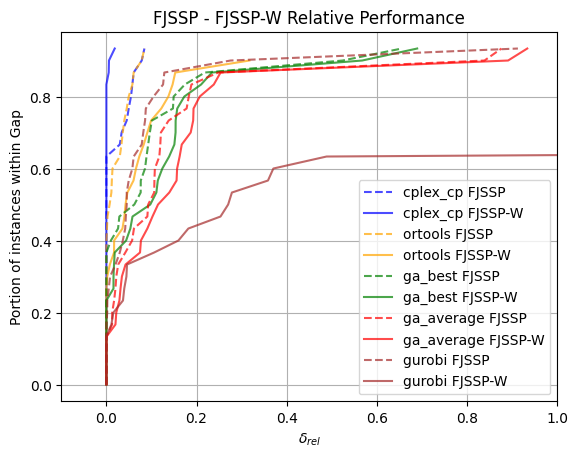

In [98]:
ecdf_inf(solver, instances=filtered_instances, labels=list(solver.keys()), colors=['blue', 'orange', 'green', 'red', 'brown', 'yellow'])

In [99]:
cp_fjssp
cp_fjssp_w
ga_best_fjssp
ga_best_fjssp_w

{'Behnke42': 80.0,
 'Behnke46': 110.0,
 'Behnke60': 491.0,
 'BrandimarteMk12': 479.0,
 'BrandimarteMk14': 640.0,
 'BrandimarteMk7': 143.0,
 'ChambersBarnes10': 949.0,
 'DPpaulli1': 2728.0,
 'DPpaulli15': 2328.0,
 'DPpaulli18': 2305.0,
 'DPpaulli9': 2270.0,
 'Fattahi14': 538.0,
 'Fattahi20': 1208.0,
 'HurinkEdata1': 51.0,
 'HurinkEdata6': 601.0,
 'HurinkRdata28': 909.0,
 'HurinkRdata38': 1780.0,
 'HurinkRdata50': 5791.0,
 'HurinkSdata1': 52.0,
 'HurinkSdata38': 2005.0,
 'HurinkSdata40': 1640.0,
 'HurinkSdata54': 7954.0,
 'HurinkSdata61': 1468.0,
 'HurinkSdata63': 605.0,
 'HurinkSdata8': 565.0,
 'HurinkVdata18': 1827.0,
 'HurinkVdata30': 1178.0,
 'HurinkVdata5': 580.0,
 'Kacem3': 7.0,
 'Kacem4': 11.0}

In [100]:
fjssp_ga_win = 0
fjssp_tie = 0
fjssp_cp_win = 0
for instance in solver['ga_best']['no_worker']:
    if instance in solver['cplex_cp']['no_worker']:
        if solver['cplex_cp']['no_worker'][instance]['fitness'] < solver['ga_best']['no_worker'][instance]['fitness']:
            fjssp_cp_win += 1
        elif solver['cplex_cp']['no_worker'][instance]['fitness'] == solver['ga_best']['no_worker'][instance]['fitness']:
            fjssp_tie += 1
        else:
            fjssp_ga_win += 1
    else:
        fjssp_ga_win += 1

fjssp_w_ga_win = 0
fjssp_w_tie = 0
fjssp_w_cp_win = 0
for instance in solver['ga_best']['worker']:
    if instance in solver['cplex_cp']['worker']:
        if solver['cplex_cp']['worker'][instance]['fitness'] < solver['ga_best']['worker'][instance]['fitness']:
            fjssp_w_cp_win += 1
        elif solver['cplex_cp']['worker'][instance]['fitness'] == solver['ga_best']['worker'][instance]['fitness']:
            fjssp_w_tie += 1
        else:
            fjssp_w_ga_win += 1
    else:
        fjssp_w_ga_win += 1

In [101]:
print(fjssp_w_ga_win)

2


In [102]:
2/30*100

6.666666666666667

In [103]:
best_fjssp = dict()
best_fjssp_w = dict()
for instance in solver['ga_best']['worker']:
    best_fjssp[instance] = float('inf')
    best_fjssp_w[instance] = float('inf')
    for s in solver:
        if instance in solver[s]['no_worker']:
            if solver[s]['no_worker'][instance]['fitness'] < best_fjssp[instance]:
                best_fjssp[instance] = solver[s]['no_worker'][instance]['fitness']
        if instance in solver[s]['worker']:
            if solver[s]['worker'][instance]['fitness'] < best_fjssp_w[instance]:
                best_fjssp_w[instance] = solver[s]['worker'][instance]['fitness']
gaps = dict()
for s in solver:
    gaps[s] = {'worker': dict(), 'no_worker': dict()}


In [104]:
for instance in solver['ga_best']['worker']:
    for s in solver:
        if instance in solver[s]['no_worker']:
            gap_fjssp = calculate_value(solver[s]['no_worker'][instance]['fitness'], best_fjssp[instance])
        if instance in solver[s]['worker']:
            gap_fjssp_w = calculate_value(solver[s]['worker'][instance]['fitness'], best_fjssp_w[instance])
        gaps[s]['worker'][instance] = gap_fjssp_w
        gaps[s]['no_worker'][instance] = gap_fjssp


In [105]:
average_gaps = dict()
for s in solver:
    avg_fjssp = 0
    avg_fjssp_w = 0
    for instance in gaps[s]['worker']:
        avg_fjssp_w += gaps[s]['worker'][instance]
    for instance in gaps[s]['no_worker']:
        avg_fjssp += gaps[s]['no_worker'][instance]
    avg_fjssp_w /= len(gaps[s]['worker'])
    avg_fjssp /= len(gaps[s]['no_worker'])
    average_gaps[s] = {'fjssp': avg_fjssp, 'fjssp_w': avg_fjssp_w}


In [106]:
average_gaps

{'cplex_cp': {'fjssp': 0.019378815612760017, 'fjssp_w': 0.0018151220888145403},
 'ortools': {'fjssp': 0.021678821290325247, 'fjssp_w': 0.06300370727023434},
 'ga_best': {'fjssp': 0.10965384441025598, 'fjssp_w': 0.13515979908491424},
 'ga_average': {'fjssp': 0.15594597728309847, 'fjssp_w': 0.18276556009403064},
 'gurobi': {'fjssp': 0.34126703848515916, 'fjssp_w': 0.7781203788900295}}

In [107]:
def get_gaps_below(data, value):
    fjssp = 0
    fjssp_w = 0
    for instance in data['no_worker']:
        if data['no_worker'][instance] <= value:
            fjssp+=1
    for instance in data['worker']:
        if data['worker'][instance] <= value:
            fjssp_w+=1
    return fjssp, fjssp_w

In [108]:
def print_gaps(data, value):
    print(f'Gap <= {value}')
    for s in data:
        fjssp, fjssp_w = get_gaps_below(data[s], value)
        print(f'{s}: FJSSP: {fjssp} ({(fjssp/30)*100}%), FJSSP-W: {fjssp_w} ({(fjssp_w/30)*100}%)')

In [109]:
print_gaps(gaps, 0)
print_gaps(gaps, 0.05)
print_gaps(gaps, 0.1)
print_gaps(gaps, 0.2)

Gap <= 0
cplex_cp: FJSSP: 18 (60.0%), FJSSP-W: 22 (73.33333333333333%)
ortools: FJSSP: 11 (36.666666666666664%), FJSSP-W: 6 (20.0%)
ga_best: FJSSP: 11 (36.666666666666664%), FJSSP-W: 4 (13.333333333333334%)
ga_average: FJSSP: 4 (13.333333333333334%), FJSSP-W: 1 (3.3333333333333335%)
gurobi: FJSSP: 6 (20.0%), FJSSP-W: 5 (16.666666666666664%)
Gap <= 0.05
cplex_cp: FJSSP: 24 (80.0%), FJSSP-W: 30 (100.0%)
ortools: FJSSP: 25 (83.33333333333334%), FJSSP-W: 18 (60.0%)
ga_best: FJSSP: 15 (50.0%), FJSSP-W: 13 (43.333333333333336%)
ga_average: FJSSP: 12 (40.0%), FJSSP-W: 11 (36.666666666666664%)
gurobi: FJSSP: 18 (60.0%), FJSSP-W: 13 (43.333333333333336%)
Gap <= 0.1
cplex_cp: FJSSP: 30 (100.0%), FJSSP-W: 30 (100.0%)
ortools: FJSSP: 30 (100.0%), FJSSP-W: 24 (80.0%)
ga_best: FJSSP: 22 (73.33333333333333%), FJSSP-W: 16 (53.333333333333336%)
ga_average: FJSSP: 16 (53.333333333333336%), FJSSP-W: 14 (46.666666666666664%)
gurobi: FJSSP: 24 (80.0%), FJSSP-W: 13 (43.333333333333336%)
Gap <= 0.2
cplex_cp:

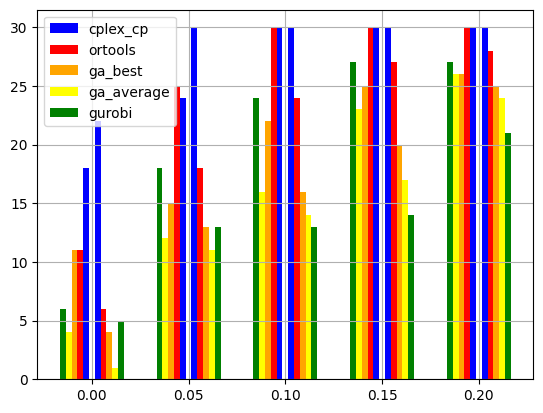

In [110]:
gap_values = [0.0, 0.05, 0.1, 0.15, 0.2]
# fjssp
colors = ['blue', 'red', 'orange', 'yellow', 'green']
i = 1
for s in solver:
    fjssp = []
    fjssp_w = []
    for gap in gap_values:
        nw, w = get_gaps_below(gaps[s], gap)
        fjssp.append(nw)
        fjssp_w.append(w)
    offset = 0.003
    x_fjssp = [value -(offset*i) for value in gap_values]
    plt.bar(x_fjssp, fjssp, width=0.003, color=colors[i-1], capstyle='round')
    x_fjssp_w = [value+(offset*i) for value in gap_values]
    plt.bar(x_fjssp_w, fjssp_w, width=0.003, label=s, color=colors[i-1])
    i+=1
plt.legend()
plt.show()

In [111]:
from benchmarkrewriter.benchmark_parser import BenchmarkParser, WorkerBenchmarkParser, WorkerEncoding
def worker_flexibility(benchmark : WorkerEncoding):
    n_assignments = 0
    m = benchmark.n_machines()
    o = benchmark.n_operations()
    durations = benchmark.durations()
    w = durations.shape[2]
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    n_assignments += 1
    average_assignments = n_assignments / o
    return average_assignments / (m*w)

def get_flexibility_and_dv_worker(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    if durations[i][j][k] not in unique:
                        unique.append(durations[i][j][k])
                    all += 1
            if any([x > 0 for x in durations[i][j]]):
                machines_available+=1
    #return (machines_available / len(durations)) / benchmark.n_machines(), len(unique) / all
    return worker_flexibility(benchmark), len(unique) / all

def get_max(durations):
    max = 0
    for operation in durations:
        for machine in operation:
            for worker in machine:
                if worker > max:
                    max = worker
    return max

def read_benchmarks_workers(path):
    result = dict()
    benchmarks = os.listdir(path)
    for benchmark in benchmarks:
        #parser = BenchmarkParser()
        parser = WorkerBenchmarkParser()
        data = parser.parse_benchmark(path + '/' + benchmark)
        #f, dv = get_flexibility_and_dv(data)
        f, dv = get_flexibility_and_dv_worker(data)
        instance_name = remap(benchmark[2:-12])
        metrics = dict()

        max_duration = get_max(data.durations())
        counts = [0] * (max_duration+1)
        for operation in data.durations():
            for machine in operation:
                for worker in machine:
                    if worker > 0:
                        counts[worker] += 1
        d_distinct = [x for x in range(len(counts)) if counts[x] > 0]
        d_unique = [x for x in range(len(counts)) if counts[x] == 1]
        d_shared = [x for x in range(len(counts)) if counts[x] > 1]
        metrics['d_distinct'] = d_distinct
        metrics['d_unique'] = d_unique
        metrics['d_shared'] = d_shared
        metrics['d_average'] = sum(counts)/data.n_operations()
        result[instance_name] = {'n_operations': data.n_operations(), 'flexibility': f, 'duration_variety': dv, 'n_machines': data.n_machines(), 'additional_metrics': metrics}

    return result

In [ ]:
fjssp_w_benchmarks = r'C:\Users\huda\Downloads\selected_benchmarks\fjssp-w'
benchmark_data = read_benchmarks_workers(fjssp_w_benchmarks)

In [ ]:
instances_ga_win = []
instances_ga_tie = []
instances_cp_win = []
for instance in solver['ga_best']['worker']:
    if instance in solver['cplex_cp']['worker']:
        if solver['cplex_cp']['worker'][instance]['fitness'] < solver['ga_best']['worker'][instance]['fitness']:
            instances_cp_win.append(instance)
        elif solver['cplex_cp']['worker'][instance]['fitness'] == solver['ga_best']['worker'][instance]['fitness']:
            instances_ga_tie.append(instance)
        else: 
            instances_ga_win.append(instance)
    else:
        instances_ga_win.append(instance)

In [ ]:
ga_attributes = {'f': [], 'o': [], 'm': [], 'dv': []}
cp_attributes = {'f': [], 'o': [], 'm': [], 'dv': []}
tied_attributes = {'f': [], 'o': [], 'm': [], 'dv': []}

for instance in instances_ga_win:
    ga_attributes['f'].append(benchmark_data[instance]['flexibility'])
    ga_attributes['o'].append(benchmark_data[instance]['n_operations'])
    ga_attributes['m'].append(benchmark_data[instance]['n_machines'])
    ga_attributes['dv'].append(benchmark_data[instance]['duration_variety'])
for instance in instances_ga_tie:
    tied_attributes['f'].append(benchmark_data[instance]['flexibility'])
    tied_attributes['o'].append(benchmark_data[instance]['n_operations'])
    tied_attributes['m'].append(benchmark_data[instance]['n_machines'])
    tied_attributes['dv'].append(benchmark_data[instance]['duration_variety'])
for instance in instances_cp_win:
    cp_attributes['f'].append(benchmark_data[instance]['flexibility'])
    cp_attributes['o'].append(benchmark_data[instance]['n_operations'])
    cp_attributes['m'].append(benchmark_data[instance]['n_machines'])
    cp_attributes['dv'].append(benchmark_data[instance]['duration_variety'])

In [ ]:
import statistics
def print_data(data):
    o = statistics.mean(data['o'])
    os = statistics.stdev(data['o'])
    f = statistics.mean(data['f'])
    fs = statistics.stdev(data['f'])
    m = statistics.mean(data['m'])
    ms = statistics.stdev(data['m'])
    dv = statistics.mean(data['dv'])
    dvs = statistics.stdev(data['dv'])
    print(f'#Operations: {o} | {os}\n#Machines: {m} | {ms}\nFlexibility: {f} | {fs}\nDuration Variety: {dv} | {dvs}')

In [ ]:
print('GA')
print_data(ga_attributes)
print('CP')
print_data(cp_attributes)
print('TIE')
print_data(tied_attributes)

GA
#Operations: 61 | 15.556349186104045
#Machines: 34.5 | 36.062445840513924
Flexibility: 0.09855807217473884 | 0.0530923034881162
Duration Variety: 0.3660989186867103 | 0.5167799273933311
CP
#Operations: 189.52380952380952 | 128.87614947988592
#Machines: 13.476190476190476 | 15.730921929814055
Flexibility: 0.1686979727584002 | 0.10165386995649085
Duration Variety: 0.1055952310527129 | 0.17206174803102736
TIE
#Operations: 72.28571428571429 | 91.03243796529213
#Machines: 8.428571428571429 | 3.5050983275386565
Flexibility: 0.23610286513854462 | 0.20835593798327018
Duration Variety: 0.14234073037548228 | 0.20183096527159172


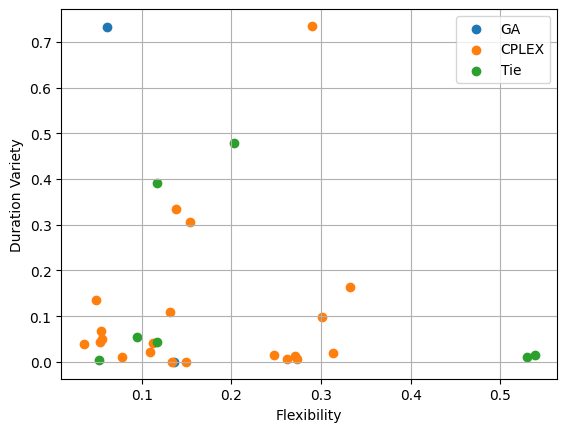

In [ ]:
x_ga = [x for x in ga_attributes['f']]
y_ga = [y for y in ga_attributes['dv']]
x_cp = [x for x in cp_attributes['f']]
y_cp = [y for y in cp_attributes['dv']]
x_tied = [x for x in tied_attributes['f']]
y_tied = [y for y in tied_attributes['dv']]
plt.scatter(x_ga, y_ga, label='GA')
plt.scatter(x_cp, y_cp, label='CPLEX')
plt.scatter(x_tied, y_tied, label='Tie')
plt.xlabel('Flexibility')
plt.ylabel('Duration Variety')
plt.legend()
plt.show()

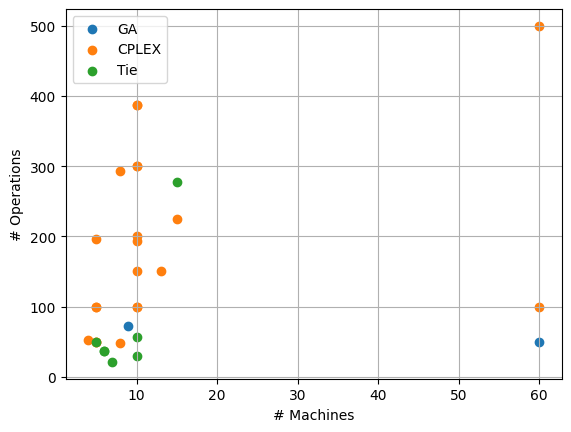

In [ ]:
x_ga = [x for x in ga_attributes['m']]
y_ga = [y for y in ga_attributes['o']]
x_cp = [x for x in cp_attributes['m']]
y_cp = [y for y in cp_attributes['o']]
x_tied = [x for x in tied_attributes['m']]
y_tied = [y for y in tied_attributes['o']]
plt.scatter(x_ga, y_ga, label='GA')
plt.scatter(x_cp, y_cp, label='CPLEX')
plt.scatter(x_tied, y_tied, label='Tie')
plt.xlabel('# Machines')
plt.ylabel('# Operations')
plt.legend()
plt.show()

In [ ]:
def get_gap_instances(data, value):
    result = []
    for instance in data['worker']:
        if data['worker'][instance] <= value:
            result.append(instance)
    return result

In [ ]:
def plot_in_gap(s):
    v1=get_gap_instances(s, 0)
    v2=get_gap_instances(s, 0.05)
    v3=get_gap_instances(s, 0.1)
    v4=get_gap_instances(s, 0.15)
    v5=get_gap_instances(s, 0.2)
    v6=get_gap_instances(s, 1.0)
    v2 = [x for x in v2 if x not in v1]
    v3 = [x for x in v3 if x not in v1 and x not in v2]
    v4 = [x for x in v4 if x not in v1 and x not in v2 and x not in v3]
    v5 = [x for x in v5 if x not in v1 and x not in v2 and x not in v3 and x not in v4]
    all = [v1, v2, v3, v4, v5]
    gaps_label=['0%', '5%', '10%', '15%', '20%']
    attributes = dict()
    for i in range(len(gaps_label)):
        attributes[gaps_label[i]] = {
        'f': [benchmark_data[x]['flexibility'] for x in all[i]],
        'dv': [benchmark_data[x]['duration_variety'] for x in all[i]],
        'o': [benchmark_data[x]['n_operations'] for x in all[i]],
        'm': [benchmark_data[x]['n_machines'] for x in all[i]],
        }
    marker = ['.', '1', '2', '3', '4']
    for i in range(len(gaps_label)):
        x = [x for x in attributes[gaps_label[i]]['f']]
        y = [y for y in attributes[gaps_label[i]]['dv']]
        plt.scatter(x, y, label=gaps_label[i], marker=marker[i])
    plt.xlabel('Flexibility')
    plt.ylabel('Duration Variety')
    plt.title('Attributes of instances $\leq \delta_{rel}$')
    plt.legend()
    plt.show()
    for i in range(len(gaps_label)):
        x = [x for x in attributes[gaps_label[i]]['m']]
        y = [y for y in attributes[gaps_label[i]]['o']]
        plt.scatter(x, y, label=gaps_label[i], marker=marker[i])
    plt.xlabel('# Machines')
    plt.ylabel('# Operations')
    plt.title('Attributes of instances $\leq \delta_{rel}$')
    plt.legend()
    plt.show()

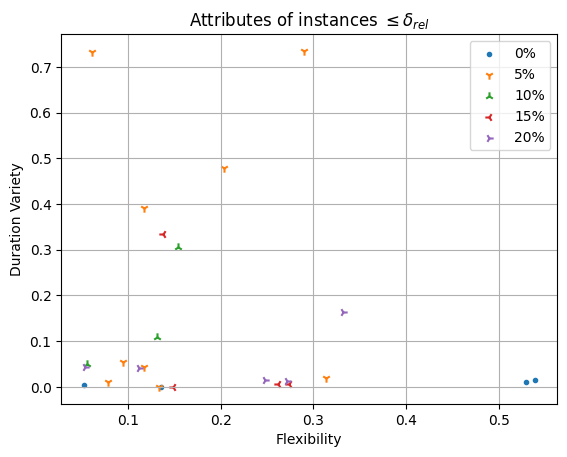

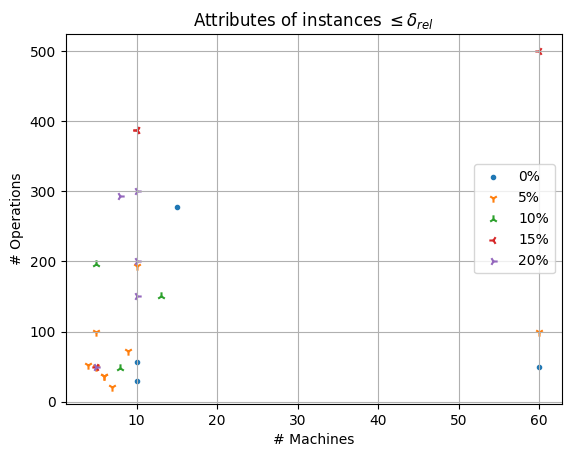

In [ ]:
plot_in_gap(gaps['ga_best'])

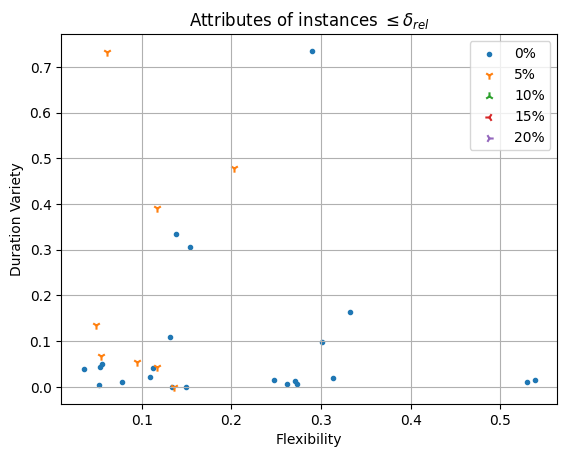

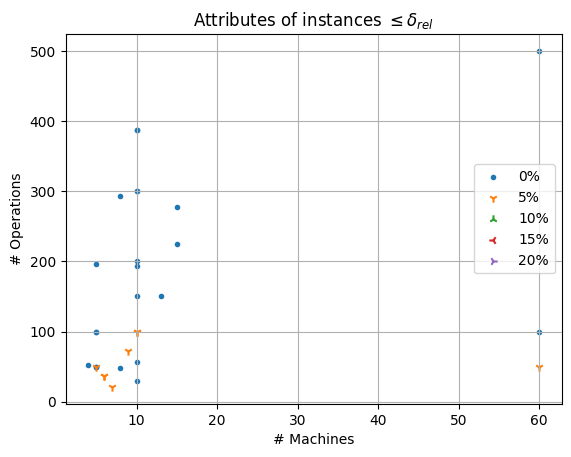

In [ ]:
plot_in_gap(gaps['cplex_cp'])